# **Breast Cancer - Comparative Analysis (Explainability with GradCAM) - NASNetLarge**

Dataset (Train and Validation) link: https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/

Annotated Dataset (Test) link: https://figshare.com/articles/dataset/BreCaHAD_A_Dataset_for_Breast_Cancer_Histopathological_Annotation_and_Diagnosis/7379186?file=13646369

Note: The test set only contains malignant class images.

The following project will focus on finding the architecture (used with GradCAM) with the best explainability efficiency. The proposed architectures for this experiment are:
* EfficientNetB0
* VisionTrasformer
* DenseNet201
* NasNetLarge
* MobileNetV3Large

This notebook represents one of the five which will run experiments with images where the Visual Magnification factor is 400x - NASNetLarge.   

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

import os
import random
from random import random, randint, seed
import pickle
import pathlib
import warnings
import platform

import cv2
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.applications import densenet, MobileNetV3Large, efficientnet, nasnet
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [40]:
print("Python- Versão: ", platform.python_version())
print("TensorFLow - Versão: ",tf.__version__)

# Checar GPUs
if not tf.test.gpu_device_name():
    warnings.warn('GPU não encontrada.')
else:
    print(f'Dispositivo GPU padrão: {tf.test.gpu_device_name()}')
    print("Número de GPUs Disponíveis: ", len(tf.config.list_physical_devices('GPU')))


Python- Versão:  3.7.13
TensorFLow - Versão:  2.8.2
Dispositivo GPU padrão: /device:GPU:0
Número de GPUs Disponíveis:  1


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
for dirpath, dirnames, filenames in os.walk('/content/drive/MyDrive/SiDi_BreakHis400x_train_val/dataset/'):
    if len(filenames)!=0:
        print(f'Existem {len(filenames)} imagens em  {dirpath}.')


Existem 1037 imagens em  /content/drive/MyDrive/SiDi_BreakHis400x_train_val/dataset/train_set/benign.
Existem 1037 imagens em  /content/drive/MyDrive/SiDi_BreakHis400x_train_val/dataset/train_set/malignant.
Existem 180 imagens em  /content/drive/MyDrive/SiDi_BreakHis400x_train_val/dataset/validation_set/malignant.
Existem 180 imagens em  /content/drive/MyDrive/SiDi_BreakHis400x_train_val/dataset/validation_set/benign.


In [42]:
train_dir = '/content/drive/MyDrive/SiDi_BreakHis400x_train_val/dataset/train_set'
val_dir = '/content/drive/MyDrive/SiDi_BreakHis400x_train_val/dataset/validation_set'
test_dir = '/content/drive/MyDrive/SiDi_BreCaHAD_test/dataset'

# Especificações para o treinamento da rede
IMG_SHAPE = (331, 331, 3)
BATCH_SIZE = 32
EPOCHS = 100

In [43]:
train_datagen = ImageDataGenerator(rescale=None)
valid_datagen = ImageDataGenerator(rescale=None)
test_datagen = ImageDataGenerator(rescale=None)

train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE,  
                                               target_size=(331, 331), 
                                               class_mode="binary")

val_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=BATCH_SIZE,  
                                               target_size=(331, 331), 
                                               class_mode="binary")

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=BATCH_SIZE,  
                                               target_size=(331, 331), 
                                               class_mode="binary")

Found 2074 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Found 159 images belonging to 2 classes.


In [44]:
 # include_top=False retira a camada do topo, ou seja, a camada densa do modelo original
basemodel = nasnet.NASNetLarge(include_top=False,
                                 weights='imagenet',
                                 input_shape=IMG_SHAPE,
                                 pooling='max')
# Note que a última camada de convolução termina com a operação de GlobalMaxPooling2D(dependendo do modelo poderia ser a Flatten)
# Assim, podemos adicionar a saída do baseModel diretamente na camada densa
# basemodel.summary()

In [45]:
# Criar a arquitetura da camada densa do modelo para o Fine Tuning
inputs = Input(shape=IMG_SHAPE)

x = tf.cast(inputs, tf.float32)
x = tf.keras.applications.nasnet.preprocess_input(x)

x = basemodel(x)

x = Dense(256, activation="relu")(x)
x = Dropout(0.2)(x)

x = BatchNormalization()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)

x = BatchNormalization()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)

x = BatchNormalization()(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.2)(x)


outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs, outputs)

In [46]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 331, 331, 3)]     0         
                                                                 
 tf.cast_2 (TFOpLambda)      (None, 331, 331, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 331, 331, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 331, 331, 3)      0         
 bda)                                                            
                                                                 
 NASNet (Functional)         (None, 4032)              84916818  
                                                                 
 dense_10 (Dense)            (None, 256)               1032

## Fine Tuning - Fase 1 (warm up) -> treina apenas a camada densa

In [47]:
# Congela as camadas do modelo base (as camadas de convolução não serão treinadas novamente)
for layer in basemodel.layers:
    layer.trainable = False  

In [48]:
base_learning_rate = 0.0001
opt = Adam(learning_rate=base_learning_rate)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [49]:
# Early Stopping do trinamento
early_stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    min_delta=0.001, 
    patience=7
)

model_ckpt = keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/callbacks/melhor_modelo_NASNetLarge_ft.hdf5', 
    monitor='val_loss', 
    save_best_only=True
)

callbacks = [early_stop, model_ckpt]

In [50]:
# Fase 1 - treina apenas com algumas épocas (40% do total)
initial_epochs = int(EPOCHS*0.4)
with tf.device('/device:GPU:0'):
  history = model.fit(train_data,
                    epochs=initial_epochs,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data), 
                    callbacks=callbacks)

Epoch 1/40
65/65 [==============================] - 204s 3s/step - loss: 0.5670 - accuracy: 0.7189 - val_loss: 0.6732 - val_accuracy: 0.5778
Epoch 2/40
65/65 [==============================] - 73s 1s/step - loss: 0.4435 - accuracy: 0.8004 - val_loss: 0.6241 - val_accuracy: 0.6306
Epoch 3/40
65/65 [==============================] - 71s 1s/step - loss: 0.4012 - accuracy: 0.8115 - val_loss: 0.5942 - val_accuracy: 0.6861
Epoch 4/40
65/65 [==============================] - 66s 1s/step - loss: 0.3684 - accuracy: 0.8327 - val_loss: 0.6556 - val_accuracy: 0.6444
Epoch 5/40
65/65 [==============================] - 73s 1s/step - loss: 0.3361 - accuracy: 0.8481 - val_loss: 0.5892 - val_accuracy: 0.6861
Epoch 6/40
65/65 [==============================] - 69s 1s/step - loss: 0.3231 - accuracy: 0.8621 - val_loss: 0.6232 - val_accuracy: 0.6889
Epoch 7/40
65/65 [==============================] - 71s 1s/step - loss: 0.2849 - accuracy: 0.8814 - val_loss: 0.5454 - val_accuracy: 0.7250
Epoch 8/40
65/65 [=

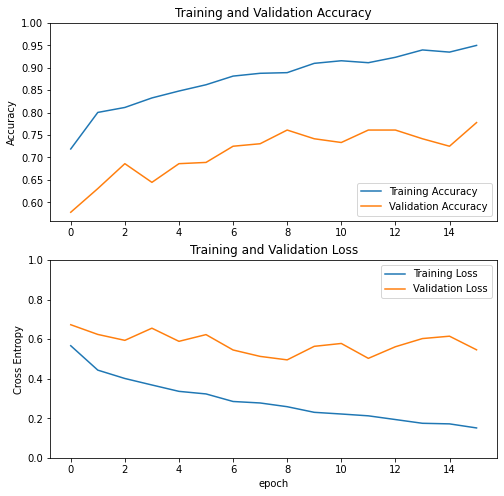

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning - Fase 2 -> treina todo o modelo do fine tuning - descongela as camadas de convolução

In [52]:
print("Número de camadas do modelo base: ", len(basemodel.layers))

Número de camadas do modelo base:  1040


In [53]:
# Descongelar as 30% camadas finais e que não seja do tipo BatchNormalization do modelo base
# Note que vpcê pode adicionar mais camadas se o modelo não for muito grande
count = 0
for layer in basemodel.layers[-int(len(basemodel.layers)*0.3):]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

In [54]:
# É necessário diminuir a base_learning_rate para que o modelo não tenha convergência muito rápida
# pois se trata d eum modelo grande
opt = Adam(learning_rate=base_learning_rate/10)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [55]:
# EarlyStopping do trinamento
early_stop2 = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    min_delta=0.001, 
    patience=7
)

model_ckpt2 = keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/callbacks/melhor_modelo_NASNetLarge_ft.hdf5', 
    monitor='val_loss', 
    save_best_only=True
)

callbacks2 = [early_stop2, model_ckpt2]

In [56]:
# Fase 2 - treina apenas com a quantidade de épocas que faltam (60% finais)
# Note que iniciará de initial_epoch=history.epoch[-1]
with tf.device('/device:GPU:0'):
  history_fine = model.fit(train_data,
                    epochs=EPOCHS,
                    initial_epoch=history.epoch[-1],
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data), 
                    callbacks=callbacks2)

Epoch 16/100
65/65 [==============================] - 130s 2s/step - loss: 0.1315 - accuracy: 0.9523 - val_loss: 0.6255 - val_accuracy: 0.7500
Epoch 17/100
65/65 [==============================] - 106s 2s/step - loss: 0.0967 - accuracy: 0.9725 - val_loss: 0.5229 - val_accuracy: 0.7972
Epoch 18/100
65/65 [==============================] - 96s 1s/step - loss: 0.0894 - accuracy: 0.9744 - val_loss: 0.5636 - val_accuracy: 0.7639
Epoch 19/100
65/65 [==============================] - 96s 1s/step - loss: 0.0781 - accuracy: 0.9807 - val_loss: 0.5655 - val_accuracy: 0.7833
Epoch 20/100
65/65 [==============================] - 106s 2s/step - loss: 0.0563 - accuracy: 0.9928 - val_loss: 0.4928 - val_accuracy: 0.7972
Epoch 21/100
65/65 [==============================] - 96s 1s/step - loss: 0.0561 - accuracy: 0.9904 - val_loss: 0.5406 - val_accuracy: 0.7972
Epoch 22/100
65/65 [==============================] - 96s 1s/step - loss: 0.0520 - accuracy: 0.9899 - val_loss: 0.5317 - val_accuracy: 0.7972
Epo

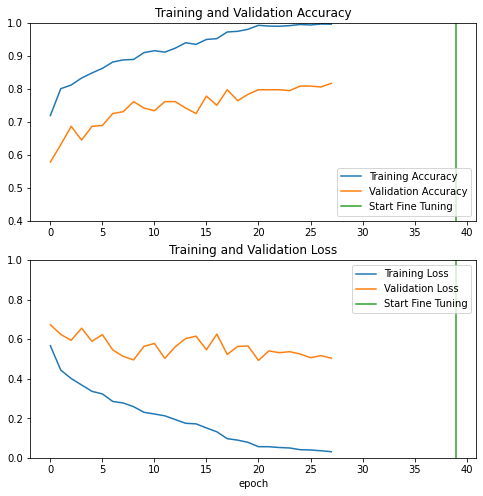

In [57]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [58]:
# Avaliação usando os dados de testes
loss, acc = model.evaluate(test_data)
print ("Test accuracy: %.3f" % acc)
print ("Test loss: %.3f" % loss)

5/5 [==============================] - 58s 14s/step - loss: 0.3128 - accuracy: 0.8616
Test accuracy: 0.862
Test loss: 0.313


In [59]:
model.save("/content/drive/MyDrive/Models_Save/SiDi_Save_Model_NASNetLarge")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models_Save/SiDi_Save_Model_NASNetLarge/assets


# GRADCAM

In [60]:
# Carrega o modelo
model = load_model("/content/drive/MyDrive/Models_Save/SiDi_Save_Model_NASNetLarge")

In [62]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 331, 331, 3)]     0         
                                                                 
 tf.cast_2 (TFOpLambda)      (None, 331, 331, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 331, 331, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 331, 331, 3)      0         
 bda)                                                            
                                                                 
 NASNet (Functional)         (None, 4032)              84916818  
                                                                 
 dense_10 (Dense)            (None, 256)               1032

In [63]:
model.layers[4].name

'NASNet'

In [64]:
basemodel=model.layers[4]

In [65]:
basemodel.summary()

Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 165, 165, 96  2592        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 165, 165, 96  384         ['stem_conv1[0][0]']             
                                )                                                            

In [66]:
last_conv_layer_name = list(filter(lambda x: isinstance(x, keras.layers.Conv2D), basemodel.layers))[-1].name
print(last_conv_layer_name) 

normal_conv_1_18


In [80]:
def get_img_array(img_path, size):

    # `img` is a PIL image of size 299x299
    img = tf.keras.utils.load_img(img_path, target_size=size)
    
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.utils.img_to_array(img)
    
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model([model.inputs], [basemodel.get_layer(last_conv_layer_name).output, model.output])
           

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, predictions = grad_model(img_array)
        predictions = tf.squeeze(predictions)
        if pred_index is None:
            pred_index = tf.argmax(predictions)
        class_channel = predictions[pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

In [81]:
# Prepare image
def generate_heatmap(img_path):
    img_array = get_img_array(img_path, size=(331, 331)) # Observação: (331, 331) apenas para a NasNet

    # Remove last layer's softmax
    # model.layers[-1].activation = None

    # Print what the top predicted class is
    preds = model.predict(img_array)
    model_preds = tf.squeeze(tf.round(preds))
    top_pred_index = tf.argmax(preds[0])

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    heat_test = heatmap.copy()

    # Display heatmap
#     print(heatmap)
#     plt.matshow(heatmap)
#     plt.show()
    
    return heatmap, class_names[top_pred_index], preds[0][top_pred_index]

In [82]:
def save_and_display_gradcam(img_path, heatmap, alpha=0.9, pred=None): #cam_path="saved/teste_1.jpg"
    
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    if pred == 'malignant':
        jet = cm.get_cmap("Reds")
    else:
        jet = cm.get_cmap("Greens")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap) #keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = np.array(jet_heatmap) # keras.preprocessing.image.img_to_array(jet_heatmap)
    
    # only for generating images
    # Superimpose the heatmap on original image
#     superimposed_img = jet_heatmap * alpha + img
#     superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
#     superimposed_img.save(cam_path)
    
    # generating mask
    jet_heatmap = cv.cvtColor(jet_heatmap, cv.COLOR_RGB2GRAY)
    _, thresh = cv.threshold(jet_heatmap, 220, 255, cv.THRESH_BINARY_INV)


    # Display Grad CAM
#     plt.imshow(superimposed_img) # comentar quando for gerar o dataframe
    
    return thresh

# Gerar dataset

In [83]:
def loading_json(filen='/content/drive/MyDrive/SiDi_BreCaHAD_test/groundTruth/'):
    tumor_cells = {}
    annot_points = {}
    
    for root, dirs, items in os.walk(filen):
        for i, item in enumerate(items):
            # Opening JSON file
            f = open(filen+item)
            # returns JSON object as 
            # a dictionary
            data = json.load(f)
            
            # adding values to dictionary
            tumor_cells[item.split('.')[0]] = len(data['tumor'])
            
            # creating list to get the annotations coordinates
            x_y = []
            for j, points in enumerate(data['tumor']):
                # list to get the coordinates of one annotation
                values_i_j = []
                
                # the values are multiplied by the image resolution
                values_i_j.append(int(points['x']*1024))
                values_i_j.append(int(points['y']*1360))
                
                # adding the coordinates to the list of one case
                x_y.append(values_i_j)
            
            # adding corresponding annotations to the respective case
            annot_points[item.split('.')[0]] = x_y

            # Closing file
            f.close()
            
    return tumor_cells, annot_points

In [84]:
def getting_probs(filen='/content/drive/MyDrive/SiDi_BreCaHAD_test/dataset/malignant/'):
    
    # loading test images
    probs = []
    classes = []
    masks = []
    for root, dirs, items in os.walk(filen):
        for item in items:
            heatmap, class_, prob = generate_heatmap(filen+item)
            mask = save_and_display_gradcam(filen+item, heatmap, class_)
            probs.append(round(prob*100,2))
            classes.append(class_)
            masks.append(mask)
            

    return classes, masks, probs

In [85]:
def checking_points(annot_points, lst_heatmaps):
    
    # list to check the correct values
    correct_values = []
    i = 0
    
    for k, v in annot_points.items():
        got_it_right = 0
        mask_matrix = lst_heatmaps[i]
        
        for a, b in enumerate(v):
            if mask_matrix[b[0]][b[1]] > 0:
                got_it_right += 1
        # adding the correct correspondences to the list      
        correct_values.append(got_it_right)
        i += 1
        
    return correct_values

In [86]:
def generating_dataset():
    
    tumor_cells, annot_points = loading_json()
    lst_classes, lst_heatmaps, lst_probs = getting_probs()
#     lst_tumors = interpretability(types=lst_classes, hmaps=lst_heatmaps)
    lst_tumors = checking_points(annot_points, lst_heatmaps)
    tumor_region = []
    accuracy = []
    
    # tumors found
    tumor_cells_values = list(tumor_cells.values())
    
    for i, qtd in enumerate(lst_tumors):
        if lst_classes[i] == 'benign':
            tumor_region.append(0)
            accuracy.append()
            
        else:
            tumor_region.append(round((qtd/tumor_cells_values[i])*100, 2))
            
    
    dataframe = pd.DataFrame(data=[tumor_cells.keys(), tumor_cells.values(), lst_classes, lst_probs,
                                  lst_tumors, tumor_region],
                             index=['Case', 'Total Tumor Cells', 'Pred. Type', 'Probability (%)',
                                     'Tumors Found' ,'Interpret. Region Accuracy (%)']).transpose()
    
    return dataframe

In [87]:
df = generating_dataset()

ValueError: ignored

In [ ]:
df.head(15)

In [ ]:

df[df['Interpret. Region Accuracy (%)'] > 90]

,Case,Total Tumor Cells,Pred. Type,Probability (%),Tumors Found,Interpret. Region Accuracy (%)


In [ ]:

# Interpretability

summ = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].sum()
stdd = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].std()
itp_model = round(summ/159, 2)
std_deviation = round(stdd/159, 2)

print(f'Model Average Interpretability (%): {itp_model} +/- {std_deviation}')

Model Average Interpretability (%): 0.0 +/- nan
